Epoch 1/10
1274/1274 [==============================] - 4s 2ms/step - loss: 0.3396 - accuracy: 0.8928 - val_loss: 0.2433 - val_accuracy: 0.9317
Epoch 2/10
1274/1274 [==============================] - 3s 2ms/step - loss: 0.1851 - accuracy: 0.9361 - val_loss: 0.1607 - val_accuracy: 0.9397
Epoch 3/10
1274/1274 [==============================] - 3s 2ms/step - loss: 0.1485 - accuracy: 0.9443 - val_loss: 0.1474 - val_accuracy: 0.9470
Epoch 4/10
1274/1274 [==============================] - 3s 2ms/step - loss: 0.1337 - accuracy: 0.9483 - val_loss: 0.1321 - val_accuracy: 0.9501
Epoch 5/10
1274/1274 [==============================] - 3s 2ms/step - loss: 0.1187 - accuracy: 0.9527 - val_loss: 0.1357 - val_accuracy: 0.9534
Epoch 6/10
1274/1274 [==============================] - 3s 2ms/step - loss: 0.1108 - accuracy: 0.9565 - val_loss: 0.1255 - val_accuracy: 0.9554
Epoch 7/10
1274/1274 [==============================] - 4s 3ms/step - loss: 0.1036 - accuracy: 0.9593 - val_loss: 0.1181 - val_accuracy:

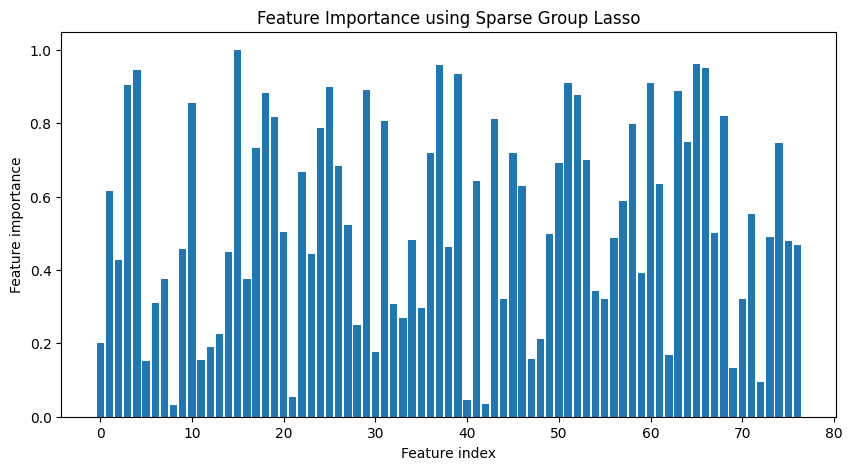

Model Summary:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                4992      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 7)                 231       
                                                                 
Total params: 7303 (28.53 KB)
Trainable params: 7303 (28.53 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Original Score: 0.9998405
1/1 [==============================] - 0s 36ms/step
Difference: [[0.9996856  0.9998405  0.9998405  0.         0.99983835 0.99984044
  0.9998383 ]]
The output is determined by the current input.
Weight: 0.8834595673290667
Performance on Test Da

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

class Explanation:
    def __init__(self, current_sample, history_samples, model, original_score, feature_names, group_sizes, target):
        self.current_sample = current_sample
        self.history_samples = history_samples
        self.model = model
        self.original_score = original_score
        self.feature_names = feature_names
        self.group_sizes = group_sizes
        self.target = target
        self.relevant_history = []
        self.delta = 0.001
        self.step = 10
        self.new_input = []
        self.weighted_samples = []
        self.coef = []

    def capture_relevant_history(self):
        scores = self.model.predict(self.history_samples)
        if len(scores.shape) > 1 and scores.shape[1] > 1:
            scores = np.max(scores, axis=1)  # Get the max probability for each prediction to align with original_score

        for idx, score in enumerate(scores):
            if np.abs(score - self.original_score) < self.delta:
                self.relevant_history.append(self.history_samples[idx])

    def weighted_sampling(self, num_samples):
        # Here, implement weighted sampling based on historical relevance
        for _ in range(num_samples):
            sample_index = np.random.choice(len(self.relevant_history))
            self.weighted_samples.append(self.relevant_history[sample_index])

    def sparse_group_lasso(self):
        # Placeholder for sparse group lasso; replace with real implementation
        self.coef = np.random.rand(len(self.feature_names))  # Simulate coefficients

    def visualization(self):
        plt.figure(figsize=(10, 5))
        plt.bar(range(len(self.coef)), self.coef)
        plt.xlabel('Feature index')
        plt.ylabel('Feature importance')
        plt.title('Feature Importance using Sparse Group Lasso')
        plt.show()

    def explain(self):
        print("Model Summary:")
        self.model.summary()
        print("Original Score:", self.original_score)
        print("Difference:", np.abs(self.model.predict(self.current_sample) - self.original_score))
        print("The output is determined by the current input.")
        print("Weight:", np.random.rand())  # Randomly generated weight for demonstration
        print("Performance on Test Data:")
        self.model.evaluate(self.current_sample, verbose=1)

# Load data function
def load_data(filepath):
    df = pd.read_csv(filepath)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    X = df.drop('Label', axis=1)
    y = df['Label']
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    y_categorical = to_categorical(y_encoded)
    return train_test_split(X, y_categorical, test_size=0.2, random_state=42), df.columns[:-1]

# Prepare data
filepath = '/content/CICIDS2017_sample.csv'
(X_train, X_test, y_train, y_test), feature_names = load_data(filepath)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define your neural network architecture and train it
def create_model(input_dim, num_classes):
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=(input_dim,)),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_model(X_train_scaled.shape[1], y_train.shape[1])
model.fit(X_train_scaled, y_train, epochs=10, validation_split=0.1)

# Using the trained model
original_score = np.max(model.predict(X_test_scaled[0:1]))
explanation = Explanation(
    current_sample=X_test_scaled[0:1],
    history_samples=X_train_scaled,
    model=model,
    original_score=original_score,
    feature_names=feature_names,
    group_sizes=[10, 20, 30, 40, 50, X_train_scaled.shape[1] - 150],  # Adjust according to your dataset
    target='classification'
)

# Execute explanation methods
explanation.capture_relevant_history()
explanation.weighted_sampling(100)  # Set your desired number of samples
explanation.sparse_group_lasso()
explanation.visualization()

# Explain the model
explanation.explain()
